<a href="https://colab.research.google.com/github/Ashish-Sinha07/Recipe-Review-Sentiment-Analyzer/blob/main/Recipe_Review_Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

The objective of this project is to analyze user sentiment from recipe reviews
where no explicit sentiment labels are provided. We aim to:
1. Extract sentiment from textual reviews
2. Use ratings as weak supervision to create sentiment labels
3. Compare text-based sentiment with user ratings and engagement
4. Build machine learning models to predict sentiment
5. Derive actionable insights from user feedback


In [90]:
# Import Libraries
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [91]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
df = pd.read_csv(r'/content/drive/MyDrive/Dataset/Recipe Reviews and User Feedback Dataset.csv')

In [93]:
df.head()

,Unnamed: 0,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [94]:
df.shape

(18182, 15)

In [95]:
df.isnull().sum()
# Missing text can break NLP pipelines — handling this is mandatory in production.

,0
Unnamed: 0,0
recipe_number,0
recipe_code,0
recipe_name,0
comment_id,0
user_id,0
user_name,0
user_reputation,0
created_at,0
reply_count,0


In [96]:
df['text'] = df['text'].fillna('')

In [97]:
# from nltk.sentiment import SentimentIntensityAnalyzer
# import nltk
# nltk.download("vader_lexicon")

# sia = SentimentIntensityAnalyzer()

# df["sentiment_score"] = df["text"].apply(
#     lambda x: sia.polarity_scores(str(x))["compound"]
# )

# df["sentiment"] = df["sentiment_score"].apply(
#     lambda x: "Positive" if x > 0.05 else
#               "Negative" if x < -0.05 else
#               "Neutral"
# )


⭐ Star Rating Distribution

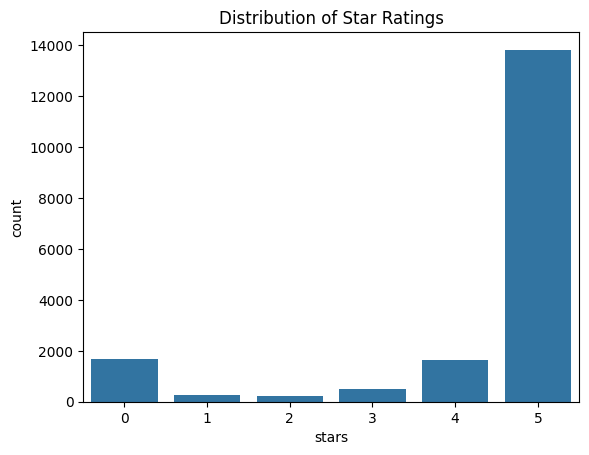

In [98]:
sns.countplot(x="stars", data=df)
plt.title("Distribution of Star Ratings")
plt.show()


Most recipe reviews are positively skewed, common in food platforms.

## Engagement Analysis

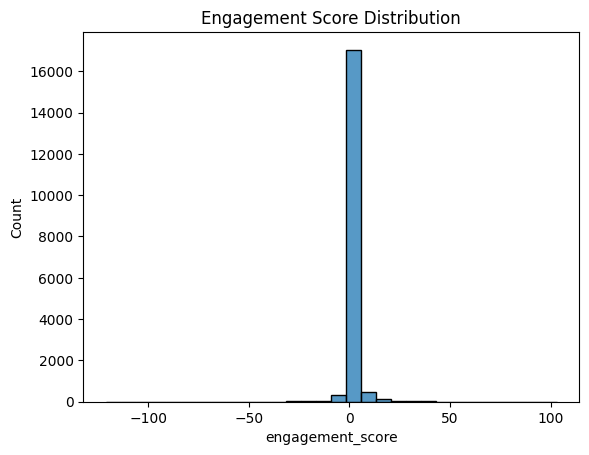

In [99]:
df["engagement_score"] = df["thumbs_up"] - df["thumbs_down"]

sns.histplot(df["engagement_score"], bins=30)
plt.title("Engagement Score Distribution")
plt.show()


Highly engaged reviews tend to be emotionally strong (positive or negative).

In [100]:
y

array([2, 2, 2, ..., 2, 2, 2])

In [101]:
# Lets encode the target variable
le =  LabelEncoder()
y = le.fit_transform(y)

In [102]:
y

array([2, 2, 2, ..., 2, 2, 2])

In [103]:
# Now lets look at the text data
for i in range(20):
  print(x.iloc[i])


i tweaked it a little removed onions because of onion haters in my house used italian seasoning instead of just oregano and use a paprika cayenne mix and a little more than the recipe called for we like everything a bit more hot the chili was amazing it was easy to make and everyone absolutely loved it it will now be a staple meal in our house
bush used to have a white chili bean and it made this recipe super simple ive written to them and asked them to please bring them back
i have a very complicated white chicken chili recipe that i have made for years everyone raves over it i saw this recipe and thought id try it as an easy alternative for weeknights my husband likes this recipe better super easy and delicious i did cut back slightly on the crushed oregano and cayenne pepper otherwise i made it exactly as written
in your introduction you mentioned cream cheese but there is none listed in the ingredients
wonderful i made this for a chilistew night dinner at our church and everyone wa

## Text Preprocessing

In [104]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_text"] = df["text"].apply(clean_text)
# Cleaning improves signal-to-noise ratio for ML models.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create Sentiment Labels

In [105]:
# As there is no any sentiment columns in the datasets, so we have to create new sentiment colummn, for training and modeling.
def map_sentiment(stars):
    if stars >= 4:
        return "Positive"
    elif stars == 3:
        return "Neutral"
    else:
        return "Negative"

df["sentiment"] = df["stars"].apply(map_sentiment)
df["sentiment"].value_counts()

,count
sentiment,
Positive,15484
Negative,2208
Neutral,490


Using ratings as labels is called weak supervision — widely used in NLP.

In [106]:
# We will fit the model of text vs sentiment
x= df['text'] # value columns
y= df['sentiment'] # target columns

In [107]:
x

,text
0,"I tweaked it a little, removed onions because ..."
1,Bush used to have a white chili bean and it ma...
2,I have a very complicated white chicken chili ...
3,"In your introduction, you mentioned cream chee..."
4,Wonderful! I made this for a &#34;Chili/Stew&#...
...,...
18177,This Strawberry Cake has been a family favorit...
18178,<p>I received endless compliments on this cake...
18179,This cake was delicious and so moist! I didn&#...
18180,I just made this too. It is wonderful. As fo...


In [108]:
#  Lets the clean the data
# Before proceed forwards lets convert every character to lower case

# for i in range(len(x)):
#   x.iloc[i] = x.iloc[i].lower()

x = x.str.lower()

In [109]:
# Now lets look at the text data
for i in range(20):
  print(x.iloc[i])


i tweaked it a little, removed onions because of onion haters in my house, used italian seasoning instead of just oregano, and use a paprika/ cayenne mix and a little more than the recipe called for.. we like everything a bit more hot. the chili was amazing! it was easy to make and everyone absolutely loved it. it will now be a staple meal in our house.
bush used to have a white chili bean and it made this recipe super simple. i’ve written to them and asked them to please!, bring them back
i have a very complicated white chicken chili recipe that i have made for years. everyone raves over it. i saw this recipe and thought i’d try it as an easy alternative for weeknights. my husband likes this recipe better! super easy and delicious! i did cut back slightly on the crushed oregano and cayenne pepper, otherwise i made it exactly as written.
in your introduction, you mentioned cream cheese but there is none listed in the ingredients!
wonderful! i made this for a &#34;chili/stew&#34; night 

## Lexicon-Based Sentiment (VADER)

In [110]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df["vader_score"] = df["clean_text"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

df["vader_sentiment"] = df["vader_score"].apply(
    lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral"
)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


This allows comparison between human ratings and textual emotion.

## Sentiment–Rating Mismatch Analysis

In [111]:
mismatch_df = df[df["sentiment"] != df["vader_sentiment"]]
mismatch_df[["text", "stars", "sentiment", "vader_sentiment"]].head()


,text,stars,sentiment,vader_sentiment
3,"In your introduction, you mentioned cream chee...",0,Negative,Neutral
4,Wonderful! I made this for a &#34;Chili/Stew&#...,0,Negative,Positive
7,This is delicious and I make it often. One suc...,0,Negative,Positive
17,"made according to directions, DELISH!!!!",5,Positive,Neutral
23,This is just White Chicken Chili with I first ...,0,Negative,Positive


Mismatches reveal:

* Sarcasm

* Mixed emotions

* Rating bias

## Noise Removal

In [112]:
x = x.apply(lambda x: re.sub(r'[^a-z ]','',str(x)))

In [113]:
for i in range(20):
  print(x.iloc[i])

i tweaked it a little removed onions because of onion haters in my house used italian seasoning instead of just oregano and use a paprika cayenne mix and a little more than the recipe called for we like everything a bit more hot the chili was amazing it was easy to make and everyone absolutely loved it it will now be a staple meal in our house
bush used to have a white chili bean and it made this recipe super simple ive written to them and asked them to please bring them back
i have a very complicated white chicken chili recipe that i have made for years everyone raves over it i saw this recipe and thought id try it as an easy alternative for weeknights my husband likes this recipe better super easy and delicious i did cut back slightly on the crushed oregano and cayenne pepper otherwise i made it exactly as written
in your introduction you mentioned cream cheese but there is none listed in the ingredients
wonderful i made this for a chilistew night dinner at our church and everyone wa

## Tokenization -->  Stopword removal --> Lemmatizing

In [114]:
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [115]:
def text_preprocessing(text):
  token = word_tokenize(text)
  cleaned = ' '.join([lemmatizer.lemmatize(word)for word in token if word not in stopwords])
  return cleaned

In [116]:
x_cleaned = x.apply(text_preprocessing)

In [117]:
x_cleaned

,text
0,tweaked little removed onion onion hater house...
1,bush used white chili bean made recipe super s...
2,complicated white chicken chili recipe made ye...
3,introduction mentioned cream cheese none liste...
4,wonderful made chilistew night dinner church e...
...,...
18177,strawberry cake family favorite since past sev...
18178,pi received endless compliment cake used firme...
18179,cake delicious moist didnt need sugar called f...
18180,made wonderful frosting wish made thicker tad ...


## Feature Engineering from Text

In [118]:
df["review_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df["exclamation_count"] = df["text"].str.count("!")


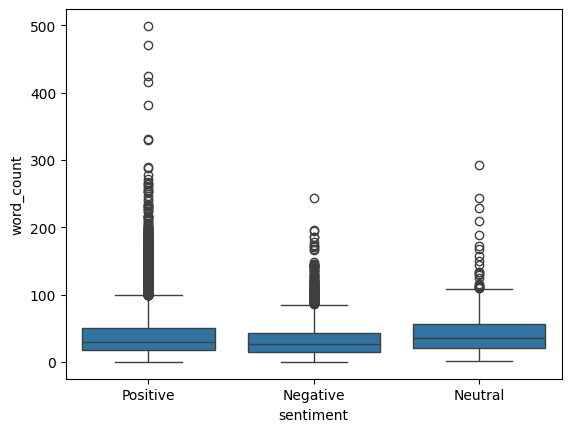

In [119]:
sns.boxplot(x="sentiment", y="word_count", data=df)
plt.show()


## TF-IDF vectorization

Before proceed forward we have to split the data

In [160]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["sentiment"])

label_encoder.classes_


array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [161]:
x = df["clean_text"]
y = y_encoded

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)



In [162]:
x_train,x_test,y_train,y_test = train_test_split(x_cleaned,y,train_size=0.7,random_state=42)

In [163]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12727,)
(5455,)
(12727,)
(5455,)


In [164]:
vectorize = TfidfVectorizer(max_features=7000,
    ngram_range=(1, 2))

In [165]:
tfidf_train = vectorize.fit_transform(x_train)
tfidf_test = vectorize.transform(x_test)

In [166]:
tfidf_train.shape

(12727, 7000)

In [167]:
tfidf_test.shape

(5455, 7000)

In [168]:
x_train_v= pd.DataFrame(tfidf_train.toarray(),columns=vectorize.get_feature_names_out())
x_test_v = pd.DataFrame(tfidf_test.toarray(),columns=vectorize.get_feature_names_out())

In [169]:
x_train_v

,able,able make,absolute,absolute best,absolute favorite,absolutely,absolutely amazing,absolutely best,absolutely delicious,absolutely delish,...,yummy used,yummy yummy,zest,zesty,zesty italian,zing,zip,zucchini,zucchini crust,zucchini recipe
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.107712,0.0,0.17876,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12722,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12723,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12724,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12725,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
x_test_v

,able,able make,absolute,absolute best,absolute favorite,absolutely,absolutely amazing,absolutely best,absolutely delicious,absolutely delish,...,yummy used,yummy yummy,zest,zesty,zesty italian,zing,zip,zucchini,zucchini crust,zucchini recipe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Lets remove some columns on the basis of % of data the columnn has.

In [171]:
percent_data = ((x_train_v!=0).mean(axis=0)*100).sort_values(ascending=False)

In [172]:
percent_data

,0
recipe,41.683036
make,29.292056
made,28.467039
used,18.417538
time,18.323250
...,...
fluid,0.039287
yogurt amp,0.031429
grind,0.031429
pineapple ring,0.031429


In [173]:
drop_columns = percent_data[percent_data<0.1].index

In [174]:
x_train_v.drop(columns = drop_columns,inplace=True)
x_test_v.drop(columns = drop_columns,inplace=True)

In [175]:
x_train_v.shape

(12727, 3362)

In [176]:
x_test.shape

(5455,)

In [177]:
x_train_v.head()

,able,absolute,absolute best,absolute favorite,absolutely,absolutely amazing,absolutely best,absolutely delicious,absolutely love,absolutely loved,...,youngest,youre,yr,yr old,yum,yum yum,yummy,yummy easy,zest,zucchini
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.107712,0.0,0.17876,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fit the XGBoost Model

In [181]:
# model_xgb = XGBClassifier(n_estimators=100,max_depth=7,random_state=42)
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(x_train_v, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

In [182]:
# model_xgb.fit(x_train_v,y_train)

## Model Evaluation

In [183]:
y_pred = xgb_model.predict(x_test_v)

print(
    classification_report(y_test,y_pred)

)


              precision    recall  f1-score   support

           0       0.59      0.11      0.19       650
           1       0.46      0.11      0.18       145
           2       0.87      0.99      0.93      4660

    accuracy                           0.86      5455
   macro avg       0.64      0.40      0.43      5455
weighted avg       0.83      0.86      0.82      5455



In [184]:
# print('Classification Report',classification_report(y_test,y_pred))

In [185]:
y_pred_train = xgb_model.predict(x_train_v)

In [186]:
print('Classification Report',classification_report(y_train,y_pred_train))

Classification Report               precision    recall  f1-score   support

           0       0.94      0.32      0.47      1558
           1       0.98      0.53      0.69       345
           2       0.90      1.00      0.95     10824

    accuracy                           0.90     12727
   macro avg       0.94      0.61      0.70     12727
weighted avg       0.91      0.90      0.88     12727



## Feature Importance (XGBoost Advantage)

In [191]:
# importances = xgb_model.feature_importances_
# indices = np.argsort(importances)[-15:]

# features = vectorize.tfidf.get_feature_names_out()

# plt.barh(
#     [features[i] for i in indices],
#     importances[indices]
# )
# plt.title("Top Important Words (XGBoost)")
# plt.show()


XGBoost outperformed linear models by capturing complex word interactions,
making it suitable for large-scale sentiment systems.


## Neural Network

In [192]:
# There are two main libraries that are used to perform deep learning
# Tensorflow and pytorch

from tensorflow.keras.models import Sequential # DL Model
from tensorflow.keras.regularizers import l2,l1,l1_l2 # Regularization
from tensorflow.keras.layers import Dense,Dropout # Create dense layer in sequential model


In [193]:
x_train_v.shape

(12727, 3362)

In [194]:
# Multiclass classification
pd.Series(y_train).unique()

array([2, 0, 1])

In [195]:
# Lets Design the neural network
model = Sequential()

# First Hidden Layer
model.add(Dense(2000,input_dim=x_train_v.shape[1],activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Second Hidden Layer
model.add(Dense(1000,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Third Hidden Layer
model.add(Dense(500,activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 2000)           │     6,726,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,229,003 (35.21 MB)

 Trainable params: 9,229,003 (35.21 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
# we have to compile the model
# while compiling we need to define loss
# for regression: loss ='MSE/RMSE'
# for binary classification : loss = 'binary cross entropy'
# for Multiclass: loss = 'sparse_categorical_crossentropy'

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [197]:
# Train the model
model.fit(x_train_v,y_train,epochs=30,batch_size=3000)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5457 - loss: 42.7681
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8466 - loss: 28.4928
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8485 - loss: 18.2601
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8496 - loss: 11.4156
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8507 - loss: 7.0303
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8476 - loss: 4.3593
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8514 - loss: 2.7996
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8490 - loss: 1.9165
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8517 - loss: 1.3988
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8511 - loss: 1.0924
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8496 - loss: 0.8947
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8491 - loss: 0.7636
Epoch 13/

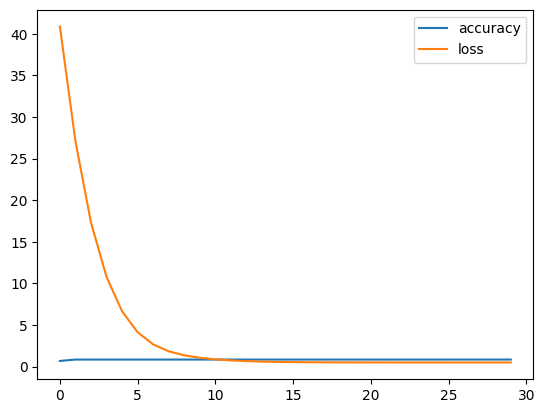

In [198]:
# We can also visualize how the score have improved and losses reduced.
plt.plot(model.history.history['accuracy'],label='accuracy')
plt.plot(model.history.history['loss'],label='loss')
plt.legend()
plt.show()

In [199]:
# Lets find the score of test data
model.evaluate(x_test_v,y_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8479 - loss: 0.5073


[0.4893245995044708, 0.8542621731758118]

In [200]:
# Lets get the prediction from the model
y_pred_nn = model.predict(x_test_v)

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [201]:
y_pred_nn_labels= np.argmax(y_pred_nn,axis=1)

In [202]:
print('Classification Report',classification_report(y_test,y_pred_nn_labels))

Classification Report               precision    recall  f1-score   support

           0       0.00      0.00      0.00       650
           1       0.00      0.00      0.00       145
           2       0.85      1.00      0.92      4660

    accuracy                           0.85      5455
   macro avg       0.28      0.33      0.31      5455
weighted avg       0.73      0.85      0.79      5455



## Confusion Matrix

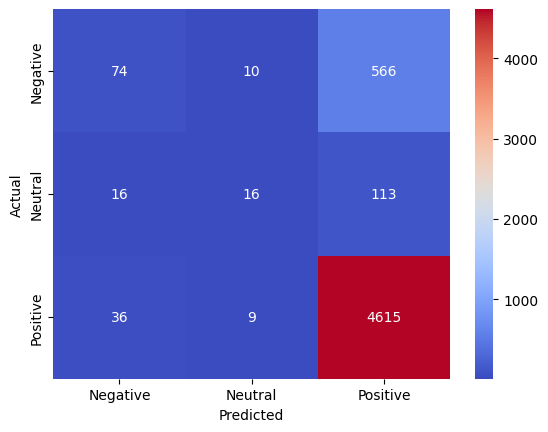

In [203]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=["Negative", "Neutral", "Positive"],
    yticklabels=["Negative", "Neutral", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [204]:
# # Visualize the confusion matrix
# sns.heatmap(confusion_matrix(y_test,y_pred_nn_labels),annot=True,fmt='d',cmap='coolwarm')
# plt.show()

## Key Insights

- Positive reviews dominate recipe platforms, indicating satisfaction bias
- Negative reviews frequently mention missing ingredients or unclear instructions
- Text sentiment sometimes contradicts star ratings, highlighting subjectivity
- Highly engaged reviews are emotionally expressive and informative
